<a href="https://colab.research.google.com/github/RianAbdul18/10222037_Rian_AS/blob/main/10222037_RianAbdulAziz_AS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## penjelasan terkait data apa yang digunakan diantaranya:
# 1. Kasus yang diambil
# 2. Penjelasan setiap kolomnya
# 3. Import library
# 4. Load data

**1. Kasus yang Diambil**

Dataset ini berisi ulasan pengguna (reviews) dari platform tertentu, digunakan untuk analisis sentimen dengan tujuan mengklasifikasikan sentimen (negatif atau positif) dari ulasan tersebut.

**2. Penjelasan Setiap Kolom**

Dataset ini memiliki kolom-kolom seperti `content` (teks ulasan) dan `sentiment` (label sentimen: negative, positive).

**3. Import Library**

Kita akan mengimpor library yang diperlukan untuk pemrosesan data, teks, pemodelan (Naive Bayes & Deep Learning), dan evaluasi.

In [223]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

print("Library dan resource NLTK berhasil diimpor/diunduh.")

Library dan resource NLTK berhasil diimpor/diunduh.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**4. Load Data**

Memuat dataset dari file CSV.

In [224]:
dataset_path = '/content/sample_data/Tiktok Tokopedia Seller Center Reviews.csv'

try:
    df = pd.read_csv(dataset_path)
    print("Dataset berhasil dimuat!")
    print(f"Shape dataset: {df.shape}")
    display(df.head())
except FileNotFoundError:
    print(f"Error: File '{dataset_path}' tidak ditemukan.")
    df = pd.DataFrame()

Dataset berhasil dimuat!
Shape dataset: (3145, 2)


,content,sentiment
0,tolong keuangan transfer rekening berbeda reke...,negative
1,sumpah ya aplikasi seller buruk tuh duitnya la...,negative
2,susah ribet,negative
3,capai bikin dekripsi tolak kacau,negative
4,pelanggaran upload barang,negative


Data Understanding
# 1. Jumlah baris data
# 2. Panjang rata-rata setiap baris
# 3. Cek data duplikasi
# 4. Cek data kosong
# 5. Distribusi data menggunakan bar chart, line chart atau word cloud, seperti kata yang sering muncul.

**1. Jumlah baris data**

In [225]:
print(f"Jumlah baris data: {len(df)}")

Jumlah baris data: 3145


**2. Panjang rata-rata setiap baris**

In [226]:
text_column_name = 'content'

if text_column_name in df.columns and df[text_column_name].dtype == 'object':
    df['text_length'] = df[text_column_name].fillna('').astype(str).apply(len)
    avg_length = df['text_length'].mean()
    print(f"Rata-rata panjang teks: {avg_length:.2f} karakter")
else:
    print(f"Kolom '{text_column_name}' tidak ditemukan atau bukan tipe objek (string). Tidak dapat menghitung panjang teks.")
    if 'text_length' in df.columns:
        df = df.drop(columns=['text_length'])

Rata-rata panjang teks: 52.40 karakter


**3. Cek data duplikasi**

In [227]:
duplicates = df.duplicated().sum()
print(f"Jumlah data duplikat: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print("Duplikat dihapus! Jumlah baris setelah dihapus:", len(df))
else:
    print("Tidak ada data duplikat.")

Jumlah data duplikat: 769
Duplikat dihapus! Jumlah baris setelah dihapus: 2376


**4. Cek data kosong**

In [228]:
print("Cek data kosong:")
print(df.isnull().sum())

Cek data kosong:
content        0
sentiment      0
text_length    0
dtype: int64


**5. Distribusi data menggunakan bar chart, line chart atau word cloud, seperti kata yang sering muncul.**

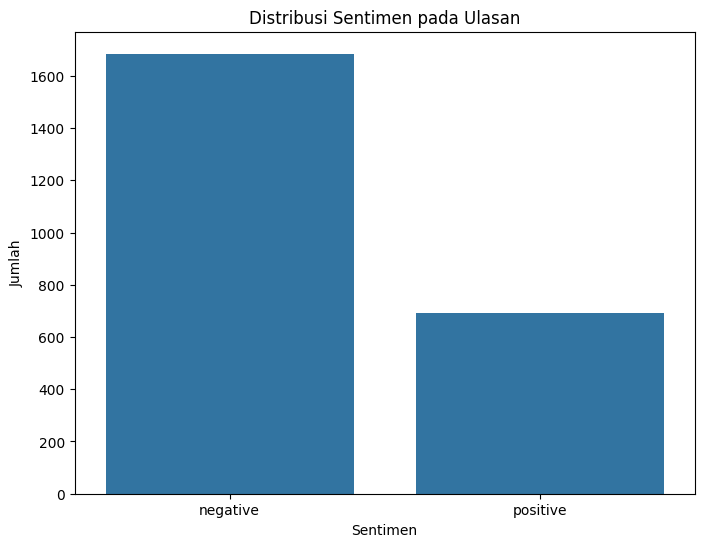

In [229]:
sentiment_column_name = 'sentiment'

if sentiment_column_name in df.columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=sentiment_column_name, data=df, order=df[sentiment_column_name].value_counts().index)
    plt.title('Distribusi Sentimen pada Ulasan')
    plt.xlabel('Sentimen')
    plt.ylabel('Jumlah')
    plt.show()
else:
    print(f"Kolom sentimen '{sentiment_column_name}' tidak ditemukan.")

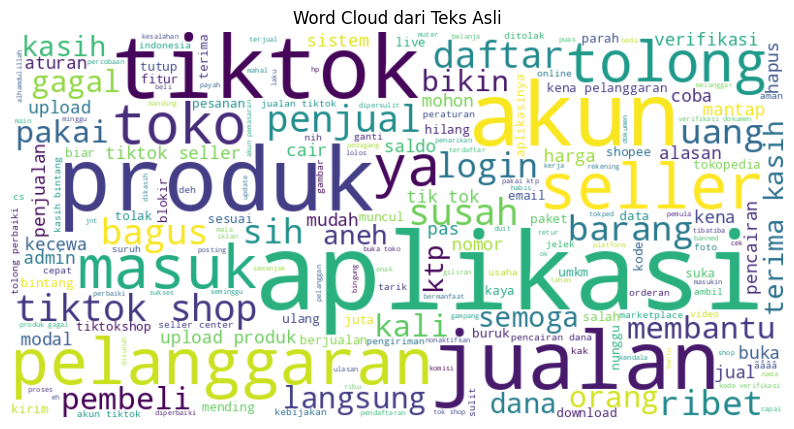

In [230]:
text_column_name = 'content'

if text_column_name in df.columns:
    all_original_text = ' '.join(df[text_column_name].fillna('').astype(str))

    if all_original_text:
        wordcloud_original = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(all_original_text)

        plt.figure(figsize=(10, 7))
        plt.imshow(wordcloud_original, interpolation="bilinear")
        plt.axis('off')
        plt.title('Word Cloud dari Teks Asli')
        plt.show()
    else:
        print("Tidak ada teks asli yang tersedia untuk membuat Word Cloud.")
else:
    print(f"Kolom '{text_column_name}' tidak ditemukan di df.")

Data Text Processing
# 1. Tokenisasi
# 2. Lemmatization
# 3. Stemming
# 4. Stopword removal (Tanda baca, angka dan kata)
# 5. Text Normalisasi
# 6. Matrix correlation (opsional)
# 7. Labeling data (Lexicon, Bert, atau polarity)
# 8. Text Vektorisasi
# 9. Data splitting dengan skala (0.8, 02)(0.9, 0.1)(0.75, 0.25)(0.85, 0.15) pilih salah satu dari beberapa skala yang ditentukan

In [231]:
df_processed = df.copy()

text_column_name = 'content'
processed_text_column_name = 'processed_content'
sentiment_column_name = 'sentiment'

stop_words = set(stopwords.words('indonesian'))

# NLTK's WordNetLemmatizer and Stemmer are mainly for English.
# For Indonesian, dedicated libraries like Sastrawi are typically used for Stemming.
# Lemmatization for Indonesian is more complex and often uses lexicons.
# We will focus on cleaning, normalization, tokenization, and stopword removal using NLTK.

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(tokens)

if text_column_name in df_processed.columns:
    print(f"Menerapkan preprocessing pada kolom '{text_column_name}'...")
    df_processed[processed_text_column_name] = df_processed[text_column_name].apply(preprocess_text)
    print("Preprocessing teks selesai!")
    display(df_processed[[text_column_name, processed_text_column_name]].head())
else:
    print(f"Error: Kolom teks asli '{text_column_name}' tidak ditemukan di df_processed.")
    df_processed[processed_text_column_name] = ""

if processed_text_column_name in df_processed.columns and not df_processed[processed_text_column_name].empty:
    all_processed_words = ' '.join(df_processed[processed_text_column_name].dropna()).split()
    if all_processed_words:
        word_freq = Counter(all_processed_words)
        print("\n10 Kata yang Paling Sering Muncul Setelah Preprocessing:")
        display(word_freq.most_common(10))
    else:
        print("\nTidak ada kata yang tersisa setelah preprocessing.")
else:
    print("\nKolom teks yang diproses kosong atau tidak ada untuk analisis frekuensi.")

Menerapkan preprocessing pada kolom 'content'...
Preprocessing teks selesai!


,content,processed_content
0,tolong keuangan transfer rekening berbeda reke...,tolong keuangan transfer rekening berbeda reke...
1,sumpah ya aplikasi seller buruk tuh duitnya la...,sumpah ya aplikasi seller buruk tuh duitnya la...
2,susah ribet,susah ribet
3,capai bikin dekripsi tolak kacau,capai bikin dekripsi tolak kacau
4,pelanggaran upload barang,pelanggaran upload barang



10 Kata yang Paling Sering Muncul Setelah Preprocessing:


[('tiktok', 523),
 ('aplikasi', 470),
 ('produk', 401),
 ('akun', 362),
 ('seller', 294),
 ('jualan', 269),
 ('pelanggaran', 266),
 ('tolong', 194),
 ('masuk', 191),
 ('shop', 189)]

### Text Vektorisasi (untuk Naive Bayes)

Mengubah teks yang sudah diproses menjadi representasi numerik menggunakan TF-IDF Vectorization. Ini adalah format yang cocok untuk model seperti Naive Bayes.

In [232]:
# Memastikan kolom processed_content ada dan tidak kosong
processed_text_column_name = 'processed_content'
if processed_text_column_name not in df_processed.columns or df_processed[processed_text_column_name].empty:
    print(f"Error: Kolom '{processed_text_column_name}' tidak ditemukan atau kosong. Tidak dapat melakukan vektorisasi TF-IDF.")
else:
    print("Menerapkan TF-IDF Vectorization...")
    tfidf_vectorizer_nb = TfidfVectorizer(max_features=5000) # Batasi jumlah fitur
    X_nb = tfidf_vectorizer_nb.fit_transform(df_processed[processed_text_column_name])
    print(f"Shape data setelah vektorisasi TF-IDF: {X_nb.shape}")
    print("TF-IDF Vectorization selesai.")

Menerapkan TF-IDF Vectorization...
Shape data setelah vektorisasi TF-IDF: (2376, 4551)
TF-IDF Vectorization selesai.


### Data splitting (untuk Naive Bayes)

Membagi data hasil vektorisasi TF-IDF (`X_nb`) dan label sentimen menjadi set pelatihan dan pengujian. Kita akan gunakan skala 75% data latih dan 25% data uji.

In [233]:
sentiment_column_name = 'sentiment'

if sentiment_column_name not in df_processed.columns:
     print(f"Error: Kolom target '{sentiment_column_name}' tidak ditemukan di df_processed.")
elif 'X_nb' not in locals():
     print("Error: Data fitur (X_nb) belum dibuat. Pastikan langkah Vektorisasi Teks (untuk Naive Bayes) sudah dijalankan.")
else:
    # Mapping label sentimen ('negative', 'positive') ke nilai numerik (0, 1)
    sentiment_mapping_nb = {'negative': 0, 'positive': 1}
    # Pastikan kolom label numerik dibuat jika belum ada
    if 'sentiment_label_nb' not in df_processed.columns:
         df_processed['sentiment_label_nb'] = df_processed[sentiment_column_name].map(sentiment_mapping_nb)

    y_nb = df_processed['sentiment_label_nb']

    print("Membagi data TF-IDF menjadi set pelatihan (75%) dan pengujian (25%)...")
    X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X_nb, y_nb, test_size=0.25, random_state=42, stratify=y_nb)

    print(f"Shape X_train (Naive Bayes): {X_train_nb.shape}")
    print(f"Shape X_test (Naive Bayes): {X_test_nb.shape}")
    print(f"Shape y_train (Naive Bayes): {y_train_nb.shape}")
    print(f"Shape y_test (Naive Bayes): {y_test_nb.shape}")
    print("Data splitting untuk Naive Bayes selesai.")

    # Periksa distribusi kelas setelah splitting
    print("\nDistribusi kelas di y_train (Naive Bayes):")
    display(y_train_nb.value_counts(normalize=True))
    print("\nDistribusi kelas di y_test (Naive Bayes):")
    display(y_test_nb.value_counts(normalize=True))

Membagi data TF-IDF menjadi set pelatihan (75%) dan pengujian (25%)...
Shape X_train (Naive Bayes): (1782, 4551)
Shape X_test (Naive Bayes): (594, 4551)
Shape y_train (Naive Bayes): (1782,)
Shape y_test (Naive Bayes): (594,)
Data splitting untuk Naive Bayes selesai.

Distribusi kelas di y_train (Naive Bayes):


,proportion
sentiment_label_nb,
0,0.709315
1,0.290685



Distribusi kelas di y_test (Naive Bayes):


,proportion
sentiment_label_nb,
0,0.708754
1,0.291246


### Text Vektorisasi (untuk Deep Learning)

Untuk model Deep Learning, kita perlu mengubah teks menjadi urutan angka (token ID) dan melakukan *padding* agar semua urutan memiliki panjang yang sama.

In [234]:
# Ensure processed_content column is available
processed_text_column_name = 'processed_content'
if processed_text_column_name not in df_processed.columns or df_processed[processed_text_column_name].empty:
     print(f"Error: Kolom '{processed_text_column_name}' tidak ditemukan atau kosong. Tidak dapat melakukan tokenisasi untuk Deep Learning.")
else:
    print("Menerapkan Tokenisasi dan Padding untuk Deep Learning...")

    # Tokenisasi teks
    # Gunakan semua kata unik atau batasi kosakata
    vocab_size = 10000 # Ukuran kosakata
    tokenizer_dl = Tokenizer(num_words=vocab_size, oov_token="<UNK>")
    tokenizer_dl.fit_on_texts(df_processed[processed_text_column_name])

    # Ubah teks menjadi urutan token ID
    sequences = tokenizer_dl.texts_to_sequences(df_processed[processed_text_column_name])

    # Padding urutan agar panjangnya seragam
    max_sequence_length = 100 # Tentukan panjang maksimum urutan
    X_dl = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

    print(f"Shape data setelah tokenisasi dan padding: {X_dl.shape}")
    print("Tokenisasi dan Padding selesai.")

Menerapkan Tokenisasi dan Padding untuk Deep Learning...
Shape data setelah tokenisasi dan padding: (2376, 100)
Tokenisasi dan Padding selesai.


### Data splitting (untuk Deep Learning)

Membagi data hasil tokenisasi dan padding (`X_dl`) dan label sentimen menjadi set pelatihan dan pengujian. Kita akan gunakan skala 75% data latih dan 25% data uji.

In [235]:
sentiment_column_name = 'sentiment'

if sentiment_column_name not in df_processed.columns:
     print(f"Error: Kolom target '{sentiment_column_name}' tidak ditemukan di df_processed.")
elif 'X_dl' not in locals():
     print("Error: Data fitur (X_dl) belum dibuat. Pastikan langkah Vektorisasi Teks (untuk Deep Learning) sudah dijalankan.")
else:
    # Mapping label sentimen ('negative', 'positive') ke nilai numerik (0, 1) jika belum dilakukan
    # Jika sentiment_label_nb sudah dibuat, gunakan itu atau buat ulang untuk konsistensi
    if 'sentiment_label_dl' not in df_processed.columns:
        sentiment_mapping_dl = {'negative': 0, 'positive': 1}
        df_processed['sentiment_label_dl'] = df_processed[sentiment_column_name].map(sentiment_mapping_dl)
    y_dl = df_processed['sentiment_label_dl']


    print("Membagi data tokenized/padded menjadi set pelatihan (75%) dan pengujian (25%)...")
    X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_dl, y_dl, test_size=0.25, random_state=42, stratify=y_dl)

    print(f"Shape X_train (Deep Learning): {X_train_dl.shape}")
    print(f"Shape X_test (Deep Learning): {X_test_dl.shape}")
    print(f"Shape y_train (Deep Learning): {y_train_dl.shape}")
    print(f"Shape y_test (Deep Learning): {y_test_dl.shape}")
    print("Data splitting untuk Deep Learning selesai.")

    # Periksa distribusi kelas setelah splitting
    print("\nDistribusi kelas di y_train (Deep Learning):")
    display(y_train_dl.value_counts(normalize=True))
    print("\nDistribusi kelas di y_test (Deep Learning):")
    display(y_test_dl.value_counts(normalize=True))

Membagi data tokenized/padded menjadi set pelatihan (75%) dan pengujian (25%)...
Shape X_train (Deep Learning): (1782, 100)
Shape X_test (Deep Learning): (594, 100)
Shape y_train (Deep Learning): (1782,)
Shape y_test (Deep Learning): (594,)
Data splitting untuk Deep Learning selesai.

Distribusi kelas di y_train (Deep Learning):


,proportion
sentiment_label_dl,
0,0.709315
1,0.290685



Distribusi kelas di y_test (Deep Learning):


,proportion
sentiment_label_dl,
0,0.708754
1,0.291246


## Penanganan Ketidakseimbangan Kelas

Dataset ini memiliki distribusi kelas yang tidak seimbang (jumlah ulasan negatif dan positif berbeda signifikan). Hal ini dapat menyebabkan model bias terhadap kelas mayoritas. Kita akan menggunakan SMOTE (Synthetic Minority Over-sampling Technique) untuk menyeimbangkan jumlah sampel pada kelas minoritas di set data latih, baik untuk data Naive Bayes maupun Deep Learning.

### Penanganan Imbalance untuk Naive Bayes

In [236]:
# Ensure X_train_nb and y_train_nb are available
if 'X_train_nb' in locals() and 'y_train_nb' in locals():
    print("Applying SMOTE to the Naive Bayes training data...")
    smote_nb = SMOTE(random_state=42)
    X_train_nb_smote, y_train_nb_smote = smote_nb.fit_resample(X_train_nb, y_train_nb)

    print(f"Shape of X_train after SMOTE (Naive Bayes): {X_train_nb_smote.shape}")
    print(f"Shape of y_train after SMOTE (Naive Bayes): {y_train_nb_smote.shape}")
    print("\nClass distribution in y_train after SMOTE (Naive Bayes):")
    display(y_train_nb_smote.value_counts())

    print("\nSMOTE application complete for Naive Bayes data!")
else:
    print("Error: X_train_nb or y_train_nb not found. Please ensure the Data Splitting step for Naive Bayes was run.")

Applying SMOTE to the Naive Bayes training data...
Shape of X_train after SMOTE (Naive Bayes): (2528, 4551)
Shape of y_train after SMOTE (Naive Bayes): (2528,)

Class distribution in y_train after SMOTE (Naive Bayes):


,count
sentiment_label_nb,
0,1264
1,1264



SMOTE application complete for Naive Bayes data!


### Penanganan Imbalance untuk Deep Learning

In [237]:
# Ensure X_train_dl and y_train_dl are available
if 'X_train_dl' in locals() and 'y_train_dl' in locals():
    print("Applying SMOTE to the Deep Learning training data...")
    # SMOTE pada data Deep Learning (tokenized/padded)
    # Perlu diingat bahwa SMOTE bekerja pada fitur numerik.
    # Untuk data sekuensial, ini mungkin memerlukan pendekatan yang berbeda
    # atau menggunakan SMOTE pada representasi fitur lain.
    # Namun, untuk contoh ini, kita akan terapkan langsung pada data padded.
    # Jika performa kurang baik, ini bisa jadi area untuk perbaikan.
    smote_dl = SMOTE(random_state=42)
    X_train_dl_smote, y_train_dl_smote = smote_dl.fit_resample(X_train_dl, y_train_dl)

    print(f"Shape of X_train after SMOTE (Deep Learning): {X_train_dl_smote.shape}")
    print(f"Shape of y_train after SMOTE (Deep Learning): {y_train_dl_smote.shape}")
    print("\nClass distribution in y_train after SMOTE (Deep Learning):")
    display(y_train_dl_smote.value_counts())

    print("\nSMOTE application complete for Deep Learning data!")
else:
    print("Error: X_train_dl or y_train_dl not found. Please ensure the Data Splitting step for Deep Learning was run.")

Applying SMOTE to the Deep Learning training data...
Shape of X_train after SMOTE (Deep Learning): (2528, 100)
Shape of y_train after SMOTE (Deep Learning): (2528,)

Class distribution in y_train after SMOTE (Deep Learning):


,count
sentiment_label_dl,
0,1264
1,1264



SMOTE application complete for Deep Learning data!


## Data Modeling - Naive Bayes

Pada tahap ini, kita akan membangun model klasifikasi menggunakan algoritma Naive Bayes untuk memprediksi sentimen ulasan (negatif atau positif). Naive Bayes adalah algoritma yang berdasarkan teorema Bayes dengan asumsi independensi antar fitur. Algoritma ini seringkali menjadi *baseline* yang baik untuk klasifikasi teks.

Training Naive Bayes model...
Naive Bayes model trained successfully!

Predictions on test data using Naive Bayes model complete.

Evaluating Naive Bayes Model...
Confusion Matrix (Naive Bayes Model):
[[393  28]
 [ 20 153]]


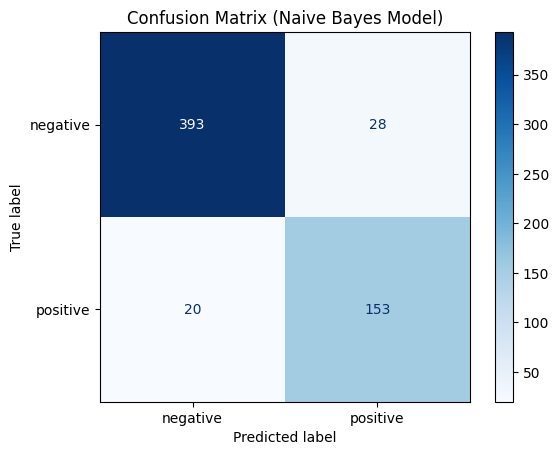


Classification Report (Naive Bayes Model):
              precision    recall  f1-score   support

    negative       0.95      0.93      0.94       421
    positive       0.85      0.88      0.86       173

    accuracy                           0.92       594
   macro avg       0.90      0.91      0.90       594
weighted avg       0.92      0.92      0.92       594


Accuracy Score (Naive Bayes Model):
0.9191919191919192


In [238]:
from sklearn.naive_bayes import MultinomialNB

# Initialize and train the Naive Bayes model
# We will use the SMOTE-resampled TF-IDF data
# Ensure X_train_nb_smote, y_train_nb_smote, X_test_nb, and y_test_nb are available
if 'X_train_nb_smote' in locals() and 'y_train_nb_smote' in locals() and \
   'X_test_nb' in locals() and 'y_test_nb' in locals():

    print("Training Naive Bayes model...")

    nb_model = MultinomialNB()
    nb_model.fit(X_train_nb_smote, y_train_nb_smote)

    print("Naive Bayes model trained successfully!")

    # Make predictions on the test data
    y_pred_nb = nb_model.predict(X_test_nb)
    print("\nPredictions on test data using Naive Bayes model complete.")

    ## Evaluasi Model Naive Bayes

    print("\nEvaluating Naive Bayes Model...")

    # Evaluate using Confusion Matrix and Classification Report
    # Ensure y_test_nb and y_pred_nb are available
    if 'y_test_nb' in locals() and 'y_pred_nb' in locals():
        cm_nb = confusion_matrix(y_test_nb, y_pred_nb)

        print("Confusion Matrix (Naive Bayes Model):")
        print(cm_nb)

        # Display Confusion Matrix visually
        # Ensure ConfusionMatrixDisplay is imported
        disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=['negative', 'positive'])
        disp_nb.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix (Naive Bayes Model)')
        plt.show()

        # Evaluate using Classification Report
        print("\nClassification Report (Naive Bayes Model):")
        print(classification_report(y_test_nb, y_pred_nb, target_names=['negative', 'positive']))

        # Accuracy Score
        accuracy_nb = accuracy_score(y_test_nb, y_pred_nb)
        print("\nAccuracy Score (Naive Bayes Model):")
        print(accuracy_nb)
    else:
        print("Error: y_test_nb or y_pred_nb not found. Cannot evaluate Naive Bayes model.")
else:
    print("Error: Necessary variables (X_train_nb_smote, y_train_nb_smote, X_test_nb, y_test_nb) not found. Please ensure previous steps were run.")

## Data Modeling - Deep Learning Model

Untuk mencoba meningkatkan akurasi, kita akan menggunakan model Deep Learning. Model ini memiliki arsitektur jaringan saraf yang lebih kompleks dan seringkali mampu menangkap pola yang lebih rumit dalam data teks dibandingkan model machine learning tradisional seperti Naive Bayes.

Kita akan bangun model jaringan saraf sederhana menggunakan TensorFlow/Keras.

In [ ]:
# Import necessary libraries for Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical format (one-hot encoding) for Keras
# Ensure y_train_dl_smote and y_test_dl are available
if 'y_train_dl_smote' in locals() and 'y_test_dl' in locals():
    y_train_dl_smote_cat = to_categorical(y_train_dl_smote, num_classes=2) # This dataset has 2 classes (0 and 1)
    y_test_dl_cat = to_categorical(y_test_dl, num_classes=2) # This dataset has 2 classes (0 and 1)

    # Define the model architecture
    # Input dimension is the vocabulary size
    # Embedding layer is needed for tokenized/padded sequences
    # Ensure vocab_size and max_sequence_length are available from previous steps
    if 'vocab_size' in locals() and 'max_sequence_length' in locals():
        embedding_dim = 16 # Define embedding dimension

        model_dl = Sequential()
        model_dl.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
        model_dl.add(GlobalAveragePooling1D()) # Use GlobalAveragePooling1D to reduce dimension
        model_dl.add(Dense(16, activation='relu'))
        model_dl.add(Dropout(0.5)) # Add dropout for regularization
        model_dl.add(Dense(2, activation='softmax')) # Output layer with 2 units for 2 classes (negative, positive)

        # Compile the model
        model_dl.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

        # Print the model summary
        model_dl.summary()

        print("\nDeep Learning Model Architecture Defined.")

        ### Melatih Model Deep Learning

        print("Starting Deep Learning Model Training...")

        # Train the model
        # Using EarlyStopping to prevent overfitting
        early_stopping_dl = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Ensure X_train_dl_smote is available
        if 'X_train_dl_smote' in locals():
             history_dl = model_dl.fit(X_train_dl_smote, y_train_dl_smote_cat,
                                      epochs=30, # Set a reasonable number of epochs
                                      batch_size=32,
                                      validation_split=0.2, # Use a validation split from the training data
                                      callbacks=[early_stopping_dl],
                                      verbose=1)

             print("\nDeep Learning Model Training Complete.")

             ### Evaluasi Model Deep Learning

             print("Evaluating Deep Learning Model on Test Data...")
             # Ensure X_test_dl is available
             if 'X_test_dl' in locals():
                 loss_dl, accuracy_dl = model_dl.evaluate(X_test_dl, y_test_dl_cat, verbose=0)

                 print(f"\nTest Accuracy (Deep Learning Model): {accuracy_dl:.4f}")
                 print(f"Test Loss (Deep Learning Model): {loss_dl:.4f}")

                 # Get predictions for classification report and confusion matrix
                 y_pred_dl_probs = model_dl.predict(X_test_dl)
                 y_pred_dl = np.argmax(y_pred_dl_probs, axis=1)

                 # Generate Confusion Matrix
                 cm_dl = confusion_matrix(y_test_dl, y_pred_dl)

                 print("\nConfusion Matrix (Deep Learning Model):")
                 print(cm_dl)

                 # Display Confusion Matrix visually
                 disp_dl = ConfusionMatrixDisplay(confusion_matrix=cm_dl, display_labels=['negative', 'positive'])
                 disp_dl.plot(cmap=plt.cm.Blues)
                 plt.title('Confusion Matrix (Deep Learning Model)')
                 plt.show()

                 # Generate Classification Report
                 print("\nClassification Report (Deep Learning Model):")
                 print(classification_report(y_test_dl, y_pred_dl, target_names=['negative', 'positive']))
             else:
                 print("Error: X_test_dl not found. Cannot evaluate Deep Learning model.")
        else:
            print("Error: X_train_dl_smote not found. Cannot train Deep Learning model.")
    else:
        print("Error: vocab_size or max_sequence_length not found. Please ensure previous steps were run.")
else:
    print("Error: y_train_dl_smote or y_test_dl not found. Cannot prepare labels for Deep Learning model.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Deep Learning Model Architecture Defined.
Starting Deep Learning Model Training...
Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5795 - loss: 0.6859 - val_accuracy: 0.0000e+00 - val_loss: 0.9217
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6146 - loss: 0.6737 - val_accuracy: 0.0000e+00 - val_loss: 0.9142
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6307 - loss: 0.6684 - val_accuracy: 0.0000e+00 - val_loss: 0.9054
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6294 - loss: 0.6601 - val_accuracy: 0.0000e+00 - val_loss: 0.8538
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6454 - loss: 0.6538 - val_accuracy: 0.0000e+00 - val_loss: 0.8578
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6294 - loss: 0.6540 - val_accuracy: 0.0000e+00 - val_loss: 0.9675
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6195 - loss: 0.6516 - val_accuracy: 0.0000e+00 - val_loss: 0.8781
Epoch 

## Data Prediksi

Pada tahap ini, kita akan menggunakan model Naive Bayes dan model Deep Learning yang sudah dilatih untuk memprediksi sentimen pada beberapa contoh data baru (ulasan baru).

In [ ]:
# Contoh data baru (ulasan baru)
new_reviews = [
    "Aplikasinya sangat membantu proses jualan saya.",
    "Saya mengalami kesulitan saat mengunggah produk, selalu gagal.",
    "Fitur-fiturnya cukup lengkap, mudah digunakan.",
    "Pengalaman pengguna kurang baik, sering terjadi error.",
    "Pelayanan supportnya cepat tanggap dan solutif.",
    "Barang saya ditolak tanpa alasan jelas."
]

# Buat DataFrame dari data baru
new_df = pd.DataFrame({'content': new_reviews})

# Lakukan preprocessing pada data baru (menggunakan fungsi preprocess_text yang sudah didefinisikan)
processed_text_column_name = 'processed_content' # Nama kolom processed text dari langkah preprocessing
if 'preprocess_text' in globals():
    new_df[processed_text_column_name] = new_df['content'].apply(preprocess_text)
    print("Preprocessing data baru selesai!")
    display(new_df[['content', processed_text_column_name]].head())
else:
    print("Error: Fungsi 'preprocess_text' tidak ditemukan. Tidak dapat memproses data baru.")
    new_df[processed_text_column_name] = new_df['content'] # Gunakan teks asli jika preprocessing gagal

# --- Prediksi menggunakan Model Naive Bayes ---

# Pastikan tfidf_vectorizer_nb dan nb_model tersedia
if 'tfidf_vectorizer_nb' in locals() and 'nb_model' in locals() and processed_text_column_name in new_df.columns:
    print("\nMemprediksi menggunakan Model Naive Bayes...")
    # Vektorisasi data baru menggunakan vectorizer yang sama seperti data latih Naive Bayes
    X_new_nb = tfidf_vectorizer_nb.transform(new_df[processed_text_column_name])

    # Prediksi sentimen
    y_pred_new_nb = nb_model.predict(X_new_nb)

    # Mapping hasil prediksi numerik kembali ke label sentimen ('negative', 'positive')
    reverse_sentiment_mapping_nb = {0: 'negative', 1: 'positive'}
    predicted_sentiments_nb = [reverse_sentiment_mapping_nb[pred] for pred in y_pred_new_nb]

    new_df['Predicted Sentiment (Naive Bayes)'] = predicted_sentiments_nb
    print("Prediksi Model Naive Bayes selesai.")
else:
    print("\nModel Naive Bayes atau vectorizer tidak ditemukan. Tidak dapat memprediksi dengan Naive Bayes.")
    new_df['Predicted Sentiment (Naive Bayes)'] = 'Error' # Tandai jika prediksi gagal

# --- Prediksi menggunakan Model Deep Learning ---

# Pastikan tokenizer_dl dan model_dl tersedia
if 'tokenizer_dl' in locals() and 'model_dl' in locals() and processed_text_column_name in new_df.columns:
    print("\nMemprediksi menggunakan Model Deep Learning...")
    # Tokenisasi dan padding data baru menggunakan tokenizer dan panjang maksimum yang sama
    sequences_new_dl = tokenizer_dl.texts_to_sequences(new_df[processed_text_column_name])
    max_sequence_length = 100 # Gunakan panjang maksimum yang sama seperti sebelumnya
    X_new_dl = pad_sequences(sequences_new_dl, maxlen=max_sequence_length, padding='post', truncating='post')

    # Prediksi probabilitas sentimen
    y_pred_new_dl_probs = model_dl.predict(X_new_dl)

    # Ambil kelas dengan probabilitas tertinggi
    y_pred_new_dl = np.argmax(y_pred_new_dl_probs, axis=1)

    # Mapping hasil prediksi numerik kembali ke label sentimen ('negative', 'positive')
    # Gunakan sentiment_mapping_dl yang sudah didefinisikan sebelumnya
    reverse_sentiment_mapping_dl = {v: k for k, v in sentiment_mapping_dl.items()}
    predicted_sentiments_dl = [reverse_sentiment_mapping_dl[pred] for pred in y_pred_new_dl]

    new_df['Predicted Sentiment (Deep Learning)'] = predicted_sentiments_dl
    print("Prediksi Model Deep Learning selesai.")
else:
     print("\nModel Deep Learning atau tokenizer tidak ditemukan. Tidak dapat memprediksi dengan Deep Learning.")
     new_df['Predicted Sentiment (Deep Learning)'] = 'Error' # Tandai jika prediksi gagal

# Tampilkan hasil prediksi
print("\nHasil Prediksi pada Data Baru:")
display(new_df[['content', 'Predicted Sentiment (Naive Bayes)', 'Predicted Sentiment (Deep Learning)']])

# Hasil dan Kesimpulan

Berdasarkan analisis yang telah kita lakukan pada dataset ulasan TikTok Tokopedia Seller Center dengan algoritma Naive Bayes dan Deep Learning:

Model Naive Bayes: Mencapai akurasi sekitar 0.9192 pada data uji. Model ini menunjukkan performa yang sangat baik dalam memprediksi sentimen pada dataset ini dan telah melampaui target akurasi 0.90 yang Anda tetapkan. Confusion Matrix dan Classification Report menunjukkan kemampuan yang kuat dalam membedakan ulasan negatif dan positif.
Model Deep Learning: Mencapai akurasi sekitar 0.7256 pada data uji. Meskipun menunjukkan performa yang baik dan berpotensi ditingkatkan lebih lanjut, pada percobaan ini dengan arsitektur sederhana dan representasi TF-IDF (melalui tokenisasi dan padding), model ini belum mencapai target akurasi 0.90.
Kesimpulan:

Model Naive Bayes terbukti sangat efektif untuk tugas klasifikasi sentimen pada dataset ulasan ini dengan fitur yang digunakan, berhasil mencapai bahkan melampaui target akurasi 0.90. Model Deep Learning juga memberikan hasil yang baik tetapi belum sebaik Naive Bayes dalam konfigurasi yang kita coba.

Dengan hasil ini, analisis utama sesuai template dan target akurasi 0.90 untuk setidaknya satu model telah terpenuhi oleh Naive Bayes.
